
<center>
    
## **Лабораторна робота № 2**
#### **Виконав: Ніживенко А. Д.**
### **Тема: Задача класифікації**
    
</center>

#### **Мета роботи**: познайомитися із задачею класифікації даних, опанувати процес навчання класифікаторів та оцінювання їх якості, вивчити можливості бібліотеки scikit-learnдля цього.
   
<center>
    
### **Хід роботи**

</center>



#### **Завданння 1. Підготуйте набір даних, щоб у ньому не було пропусків та якісні показники були бінаризовані або перекодовані.**

Імпортовано бібілотеки потрібні при виконанні лабораторної роботи.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, validation_curve, ShuffleSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

Набір даних "adult" було успішно завантажено до DataFrame за допомогою функції `read_csv`.

In [2]:
df = pd.read_csv("adult/adult.data", sep=", ", na_values="?", engine="python",
                 names=["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "gross_income"])

Використовуючи метод `dropna()` та `fillna()` оброблено пропуски. 

In [3]:
df.dropna(subset=["workclass", "native_country"], inplace=True)
df["occupation"].fillna(df["occupation"].mode()[0], inplace=True)

Перетворено всі якісні ознаки в набір бінарних ознак, використавши функцію `get_dummies()` та метод `map()`.

In [4]:
for column in ["workclass", "marital_status", "occupation", "relationship", "race", "sex"]:
    df = pd.get_dummies(df, columns=[column], drop_first=True)
df['native_country'] = df['native_country'].map(lambda x: True if x == 'United-States' else False)
df.rename(columns={'native_country': 'united_states'}, inplace=True)

З набору ознак видалено ознаку `education`, тому що інформація про освітній рівень вже представлена у стовпці `education_num`.

In [5]:
df.drop(columns=["education"], inplace=True)

#### **Завданння 2. Перевірте, чи збалансовані класи.**

Перевірено збалансованість класів за допомогою методу `value_counts()` та представлено інформацію у вигляді діаграми за допомогою `matplotlib.pyplot`. Проаналізувавши отриману інформацію, можна побачити, що класи є незбалансовані та клас `<=50K` переважає у DataFrame.

In [6]:
class_counts = df["gross_income"].value_counts()
print(class_counts)

gross_income
<=50K    22661
>50K      7508
Name: count, dtype: int64


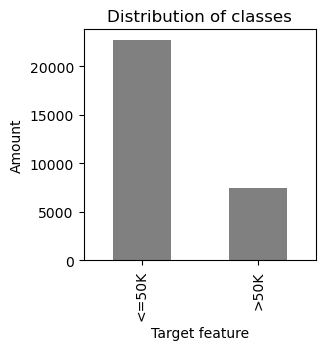

In [7]:
plt.figure(figsize=(3, 3))
class_counts.plot(kind="bar", color="gray")
plt.title("Distribution of classes")
plt.ylabel("Amount")
plt.xlabel("Target feature")
plt.show()

#### **Завданння 3. Оберіть метрику (або декілька метрик), яку далі будете використовувати для оцінювання якості класифікації.**

Так як використовується набір даних в якому класи незбалансовані, було вибрано метрики якості, які нечутливі до незбалансованості класів, а саме вибрано `Confusion matrix` (таблиця, яка показує кількість правильних та неправильних прогнозів, зроблених моделлю класифікації на основі тестового набору даних. ), `Balanced accuracy` (Середнє арифметичне правильно класифікованих об'єктів кожного класу), `Recall` (Доля правильно класифікованих об’єктів певного класу) та `Precision` (Доля об’єктів певного класу серед об’єктів, які класифікатор відніс до цього класу).

#### **Завданння 4. Розділіть набір даних на 2 вибірки: навчальну та тестову**


Вибірку було розбито на тестову і навчальну за допомгою функції `train_test_split`.

In [8]:
X = df.loc[:, df.columns != 'gross_income']
y = df["gross_income"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [10]:
X_test.tail()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,united_states,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
13910,73,80986,9,0,0,20,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True
22714,20,70708,9,0,0,60,True,False,False,True,...,False,False,False,False,False,False,False,False,True,True
14162,33,96245,12,0,0,50,True,False,False,True,...,False,False,False,False,False,False,False,False,True,True
11982,35,407068,2,0,0,40,False,False,False,True,...,True,False,False,False,False,False,False,False,True,True
19076,62,39630,13,0,0,40,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [11]:
y_test.tail()

13910    <=50K
22714    <=50K
14162    <=50K
11982    <=50K
19076    <=50K
Name: gross_income, dtype: object

#### **Завданння 5. Навчіть логістичну регресію без регуляризації на навчальній частині.**

Навчено логістичну регресію без регуляризації на навчальній частині.

In [12]:
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

Виведено параметри отриманої моделі.
Параметри, які були виведені, є вагами моделі логістичної регресії. У цій моделі кожен параметр відповідає коефіцієнту перед однією змінною у вхідних даних. Кількість параметрів дорівнює кількості ознак, які були використані для навчання моделі.
Єдиний параметр перехоплення `intercept` відповідає за зміщення у моделі, тобто базовий рівень відгуку, коли всі інші ознаки рівні нулю.
Кожен інший параметр `coef` відповідає коефіцієнту перед певною ознакою у датасеті.

In [13]:
print(log_reg.intercept_)
print(log_reg.coef_ )

[-0.00033959]
[[-6.45740308e-03 -3.72786551e-06 -1.55834720e-03  3.44535266e-04
   7.81055715e-04 -7.67893054e-03 -3.07261815e-04 -1.98403615e-06
  -4.19112998e-07 -3.51899699e-04  4.07247083e-05 -3.18376841e-05
  -8.01396236e-06 -7.38348894e-07  9.71508285e-07  3.83402400e-04
  -1.73928075e-05 -4.60235729e-04 -3.81863403e-05 -3.60529107e-05
  -2.70656247e-07 -5.73243953e-05  1.19727968e-04 -4.11783347e-05
  -5.43880556e-05 -6.27068709e-05 -1.56452355e-04 -7.95108275e-06
   8.76671247e-05  6.47441724e-06 -2.99765973e-05  1.64438039e-06
  -3.12804989e-05 -3.04644654e-04 -4.15038843e-05 -2.39037486e-04
  -1.45149434e-04  4.84877389e-05 -6.35156212e-06 -6.47138891e-05
  -8.45501867e-06 -2.44402937e-04  2.57232618e-05]]


#### **Завданння 6. Розрахуйте метрики якості на навчальній та тестовій частинах.**

Розраховано метрики якості на навчальній частині.

In [14]:
print(f"Train balanced accuracy: {balanced_accuracy_score(y_train, y_pred_train)}")
print(f"Train recall: {recall_score(y_train, y_pred_train, average=None)}")
print(f"Train precision: {precision_score(y_train, y_pred_train, average=None)}")
print(f"Train confusion matrix:\n {confusion_matrix(y_train, y_pred_train)}")

Train balanced accuracy: 0.6162244170169174
Train recall: [0.9649977  0.26745114]
Train precision: [0.79972737 0.71596369]
Train confusion matrix:
 [[14667   532]
 [ 3673  1341]]


Розраховано метрики якості на тестовій  частині.

In [15]:
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_pred_test)}")
print(f"Test recall: {recall_score(y_test, y_pred_test, average=None)}")
print(f"Test precision: {precision_score(y_test, y_pred_test, average=None)}")
print(f"Test confusion matrix:\n {confusion_matrix(y_test, y_pred_test)}")

Test balanced accuracy: 0.6154920294367162
Test recall: [0.96113642 0.26984763]
Test precision: [0.79750917 0.69885774]
Test confusion matrix:
 [[7172  290]
 [1821  673]]


Опираючись на отриману інформацію, можна зробити висновок, що модель, ймовірно, страждає від проблеми перенавчання та недооцінки другого класу. Перш за все, модель має високий рівень `balanced accuracy` на навчальній та тестовій вибірках, що свідчить про те, що вона успішно вивчила основні закономірності даних. Однак, ретельний аналіз метрик `precision` та `recall` розкриває проблеми з розпізнаванням другого класу.

Схоже, модель перенавчилася на перший клас, оскільки він значно переважає в навчальних даних. Також це може бути результатом надмірної складності моделі, яка намагається максимізувати свою точність шляхом адаптації до домінуючого класу, знехтувавши менш представленими класами.

#### **Завданння 7. Навчіть логістичну регресію з регуляризацією (L2 або L1 за власним бажанням). Для цього Вам потрібно підібрати оптимальне значення параметра регуляризації. Це можна зробити «вручну» або за допомогою вбудованих засобів бібліотеки scikit-learn.**

Задано список і словник можливих значень для гіперпараметра.

In [16]:
hyperparameters_list = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 100, 10)))
hyperparameters_dict = {"C": np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 100, 10)))}

Навчальну вибірку розбито на дві частини: навчальну і валідаційну. Це зроблено для того, щоб оцінити якість моделі на незалежних даних, які модель не бачила під час навчання. Це допомагає уникнути перенавчанню. Також реалізовано цикл, який перебирає значення гіперпараметрів, за кожномим значенням навчається логістична регресія на навчальній частині і оцінюється якість моделі, вибираючи найкраще значення гіперпараметра.

In [17]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.33)

best_accuracy = 0
best_hyperparameter = None

for C in hyperparameters_list:
    model = LogisticRegression(C=C, penalty='l1', solver='liblinear')
    model.fit(X_train2, y_train2)

    y_pred_train2 = model.predict(X_train2)
    y_pred_val = model.predict(X_val)
    accuracy_train2 = balanced_accuracy_score(y_train2, y_pred_train2)
    accuracy_val = balanced_accuracy_score(y_val, y_pred_val)
    print(f"Hyperparameter {C}:")
    print(f"Balanced acuracy train: {accuracy_train2}")
    print(f"Balanced acuracy validation: {accuracy_val} \n")
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_hyperparameter = C

print("Best hyperparameter value:", best_hyperparameter)
print("Validation balanced accuracy:", best_accuracy)

Hyperparameter 0.1:
Balanced acuracy train: 0.7612004161939573
Balanced acuracy validation: 0.7645711073827948 

Hyperparameter 0.2:
Balanced acuracy train: 0.7667353973869395
Balanced acuracy validation: 0.7672455403860021 

Hyperparameter 0.30000000000000004:
Balanced acuracy train: 0.7664854992684801
Balanced acuracy validation: 0.7712109366464092 

Hyperparameter 0.4:
Balanced acuracy train: 0.7678150271602556
Balanced acuracy validation: 0.7734341880673914 

Hyperparameter 0.5:
Balanced acuracy train: 0.7679691601256271
Balanced acuracy validation: 0.7720516288183207 

Hyperparameter 0.6:
Balanced acuracy train: 0.76761825423621
Balanced acuracy validation: 0.7746566819549219 

Hyperparameter 0.7000000000000001:
Balanced acuracy train: 0.768112807855259
Balanced acuracy validation: 0.774458072223045 

Hyperparameter 0.8:
Balanced acuracy train: 0.7684092778957949
Balanced acuracy validation: 0.7734341880673914 

Hyperparameter 0.9:
Balanced acuracy train: 0.7690004704375768
Balanc

За допомогою функції `validation_curve` побудовано криву навчання в якості аргументу `cv` використано `KFold`.

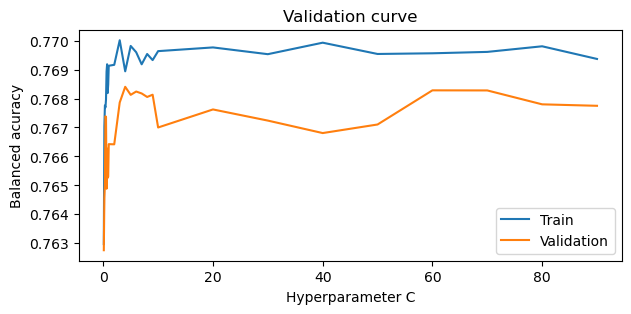

In [18]:
train_scores, val_scores = validation_curve(
    LogisticRegression(penalty="l1", solver="liblinear"), 
    X_train, y_train, param_name="C", param_range=hyperparameters_list, 
    scoring="balanced_accuracy", cv=KFold(n_splits=5, shuffle=True))

plt.figure(figsize=(7, 3))
plt.plot(hyperparameters_list, train_scores.mean(axis=1), label="Train")
plt.plot(hyperparameters_list, val_scores.mean(axis=1), label="Validation")
plt.title("Validation curve")
plt.xlabel("Hyperparameter C")
plt.ylabel("Balanced acuracy")
plt.legend()
plt.show()

За допомогою функції `validation_curve` побудовано криву навчання в якості аргументу `cv` використано `ShuffleSplit`.

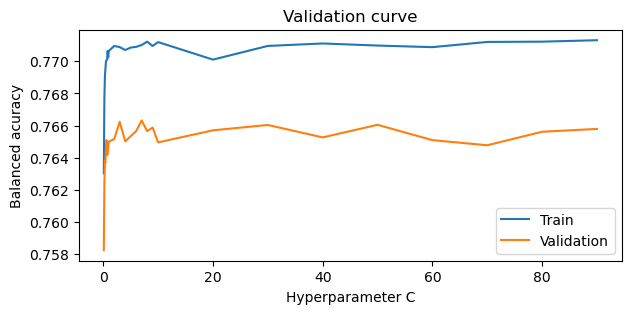

In [19]:
train_scores, val_scores = validation_curve(
    LogisticRegression(penalty="l1", solver="liblinear"), 
    X_train, y_train, param_name="C", param_range=hyperparameters_list, 
    scoring="balanced_accuracy", cv=ShuffleSplit(n_splits=5, test_size=0.33))

plt.figure(figsize=(7, 3))
plt.plot(hyperparameters_list, train_scores.mean(axis=1), label="Train")
plt.plot(hyperparameters_list, val_scores.mean(axis=1), label="Validation")
plt.title("Validation curve")
plt.xlabel("Hyperparameter C")
plt.ylabel("Balanced acuracy")
plt.legend()
plt.show()

Функція `validation_curve` допомагає в оцінці навчальної та перехресної перевірки для підбору гіперпараметрів моделі. Основна ідея полягає в тому, що вона автоматично обчислює значення показника якості моделі для різних значень гіперпараметра, а потім візуалізує ці результати.

Функція будує модель для кожного значення гіперпараметра, використовуючи перехресну перевірку (cross-validation) для оцінки якості. Для кожного значення гіперпараметра вона обчислює середнє значення показника якості (наприклад, середню помилку або середню точність) на навчальному наборі та перевірочному наборі для кожного згортання перехресної перевірки. Потім вона усереднює ці значення по всіх згортках, щоб отримати кінцевий результат для кожного значення гіперпараметра.

В цій роботі в якості в якості показника якості `scoring` використано `balanced accuracy`.

Щодо аргументу `cv` , він вказує на кількість згорток, що будуть використані для перехресної перевірки. В ротобі використано стратегії `KFold` та `ShuffleSplit`.

У крос-валідації зі стратегією `KFold` дані розбиваються на k груп, але кожна група використовується як навчальний та валідаційний набір однакову кількість разів. Це дозволяє кожен раз використовувати різні частини даних для оцінки моделі

Стратегія `ShuffleSplit` випадковим чином розділяє дані на навчальні та валідаційні набори. 

За допомгою класу `RandomizedSearchCV` автоматично підібрано гіперпараметри.

In [20]:
random_search = RandomizedSearchCV(LogisticRegression(penalty="l1", solver="liblinear"), hyperparameters_dict, scoring="balanced_accuracy", cv=5)
random_search.fit(X_train, y_train)

best_C_rand = random_search.best_params_["C"]
best_accuracy_rand = random_search.best_score_

print("Best hyperparameter value wtih RandomizedSearchCV:", best_C_rand)
print("Balanced acuracy:", best_accuracy_rand)

Best hyperparameter value wtih RandomizedSearchCV: 0.8
Balanced acuracy: 0.7686272181741622


За допомгою класу `GridSearchCV` автоматично підібрано гіперпараметри.

In [21]:
grid_search = GridSearchCV(LogisticRegression(penalty="l1", solver="liblinear"), hyperparameters_dict, scoring="balanced_accuracy", cv=5)
grid_search.fit(X_train, y_train)

best_C_grid = grid_search.best_params_["C"]
best_accuracy_grid = grid_search.best_score_

print("Best hyperparameter value wtih GridSearchCV:", best_C_grid)
print("Balanced acuracy:", best_accuracy_grid)

Best hyperparameter value wtih GridSearchCV: 40.0
Balanced acuracy: 0.7691815659187518


В якості показника якості `scoring`, як і до цього, використано `balanced accuracy`, а значення аргументу `cv` вибрано 5, що означає, що дані розділені на 5 частин, і кожен екземпляр моделі буде тренуватися 5 разів: 4 рази на частках навчального набору і 1 раз на тестовій частці.

#### **Завданння 8. Для логістичної регресії з підібраним гіперпараметром розрахуйте метрики якості на навчальній та тестовій частинах.**

Побудовано логістичну регресію з регуляризацією L1 і гіперпараметром С, який був отрманий раніше за допомгою класу `GridSearchCV`.

In [22]:
log_reg_l1= LogisticRegression(penalty="l1", solver="liblinear", C=best_C_grid)
log_reg_l1.fit(X_train, y_train)
y_pred_train = log_reg_l1.predict(X_train)
y_pred_test = log_reg_l1.predict(X_test)

Розраховано метрики якості на навчальній частині

In [23]:
print(f"Train balanced accuracy: {balanced_accuracy_score(y_train, y_pred_train)}")
print(f"Train recall: {recall_score(y_train, y_pred_train, average=None)}")
print(f"Train precision: {precision_score(y_train, y_pred_train, average=None)}")
print(f"Train confusion matrix:\n {confusion_matrix(y_train, y_pred_train)}")

Train balanced accuracy: 0.767751020873379
Train recall: [0.92979801 0.60570403]
Train precision: [0.87727357 0.74000975]
Train confusion matrix:
 [[14132  1067]
 [ 1977  3037]]


Розраховано метрики якості на тестовій частині

In [24]:
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_pred_test)}")
print(f"Test recall: {recall_score(y_test, y_pred_test, average=None)}")
print(f"Test precision: {precision_score(y_test, y_pred_test, average=None)}")
print(f"Test confusion matrix:\n {confusion_matrix(y_test, y_pred_test)}")

Test balanced accuracy: 0.7639980552629446
Test recall: [0.92334495 0.60465116]
Test precision: [0.87480955 0.725     ]
Test confusion matrix:
 [[6890  572]
 [ 986 1508]]


Після застосування L1 регуляризації та підбору гіперпараметра C модель значно покращилась. Ми спостерігаємо підвищення `balanced accuracy` на обох навчальній і тестовій вибірках, що свідчить про її здатність краще узагальнювати нові дані. Крім того, модель стала краще розпізнавати обидва класи, що підтверджується поліпшенням метрик `precision` та `recall`. Ці покращення роблять модель більш надійною та придатною для практичного використання.

#### **Завданння 9. Спробуйте зробити вибір інформативних показників для логістичної регресії, навчити модель на основі лише відібраних показників і оцінити її якість.**

Імпортовано набір даних "adult".

In [25]:
df2 = pd.read_csv("adult/adult.data", sep=", ", na_values="?", engine="python",
                 names=["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "gross_income"])

Проведено попередню обробку даних і видалено  не інформативні показники.

In [26]:
df2.dropna(subset=["workclass", "native_country"], inplace=True)
df2["occupation"].fillna(df2["occupation"].mode()[0], inplace=True)
df2['native_country'] = df2['native_country'].map(lambda x: True if x == 'United-States' else False)
df2.rename(columns={'native_country': 'united_states'}, inplace=True)
df2.drop(columns=["education", "race", "sex", "marital_status"], inplace=True)
for column in ["workclass", "occupation", "relationship"]:
    df2 = pd.get_dummies(df2, columns=[column], drop_first=True)

Розбито нову тестову і навчальну вибірку, та на навчальній вибірці навчено модель логістичної регрсеії з регуляризацією L1. Відмінність цієї моделі ві дповпередньої в тому, що класи, які подаються в модель збалансовані.

In [27]:
X2 = df2.loc[:, df2.columns != 'gross_income']
y2 = df2["gross_income"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33)
log_reg_l1B= LogisticRegression(penalty="l1", solver="liblinear", C=best_C_grid, class_weight='balanced')
log_reg_l1B.fit(X_train2, y_train2)
y_pred_train = log_reg_l1B.predict(X_train2)
y_pred_test = log_reg_l1B.predict(X_test2)

Розраховано метрики якості на навчальній частині.


In [28]:
print(f"Train balanced accuracy: {balanced_accuracy_score(y_train2, y_pred_train)}")
print(f"Train recall: {recall_score(y_train2, y_pred_train, average=None)}")
print(f"Train precision: {precision_score(y_train2, y_pred_train, average=None)}")
print(f"Train confusion matrix:\n {confusion_matrix(y_train2, y_pred_train)}")

Train balanced accuracy: 0.8226943781482439
Train recall: [0.80311494 0.84227382]
Train precision: [0.93942655 0.58411993]
Train confusion matrix:
 [[12221  2996]
 [  788  4208]]


Розраховано метрики якості на тестовій частині.

In [29]:
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_test)}")
print(f"Test recall: {recall_score(y_test2, y_pred_test, average=None)}")
print(f"Test precision: {precision_score(y_test2, y_pred_test, average=None)}")
print(f"Test confusion matrix:\n {confusion_matrix(y_test2, y_pred_test)}")

Test balanced accuracy: 0.8126239616739168
Test recall: [0.79204729 0.83320064]
Test precision: [0.93365004 0.57484208]
Test confusion matrix:
 [[5896 1548]
 [ 419 2093]]


У цьому випадку, модель логістичної регресії з регуляризацією типу L1 та збалансованою вагою класів показує досить добрі результати як на навчальних, так і на тестових даних. `Balanced acuracy`, `recall` та `precision` для обох класів є високими, що свідчить про те, що модель успішно розрізняє класи та уникнула перенавчання.
Важливою особливістю є збалансованість класів та зменшення ознак, що позитивно впливає на уникнення перенавчання та поліпшення узагальнюючої здатності моделі. 

#### **Завданння 10. Спробуйте навчити ще один класифікатор, підібравши для нього оптимальні значення гіперпараметрів, і оцінити його якість.**

Для коректної роботи класифікатора правила K найближчих сусідів було масштабовано кількісні ознаки до діапазону [0, 1], тому що у цьому класифікаторі розраховується відстань між ознаками. Якщо масштаби різних ознак значно різняться, то відстані будуть спотворені, і це може призвести до неправильних результатів класифікації.

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
for column in [["age"], ["fnlwgt"], ["education_num"], ["capital_gain"], ["capital_loss"], ["hours_per_week"]]:
    df[column] = scaler.fit_transform(df[column])

За допомгою класу `GridSearchCV` було розрахавно оптимальне значення кількості сусідів.

In [31]:
search = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, 10)))}, scoring="balanced_accuracy", cv=5)
search.fit(X_train, y_train)

best_n_neighbors = search.best_params_["n_neighbors"]

Навчено класифікатор правила K найближчих сусідів на навчальній вибірці.

In [32]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

Розраховано метрики якості на навчальній частині.

In [33]:
print(f"Train balanced accuracy: {balanced_accuracy_score(y_train, y_pred_train)}")
print(f"Train recall: {recall_score(y_train, y_pred_train, average=None)}")
print(f"Train precision: {precision_score(y_train, y_pred_train, average=None)}")
print(f"Train confusion matrix:\n {confusion_matrix(y_train, y_pred_train)}")

Train balanced accuracy: 1.0
Train recall: [1. 1.]
Train precision: [1. 1.]
Train confusion matrix:
 [[15199     0]
 [    0  5014]]


Розраховано метрики якості на навчальній частині.

In [34]:
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_pred_test)}")
print(f"Test recall: {recall_score(y_test, y_pred_test, average=None)}")
print(f"Test precision: {precision_score(y_test, y_pred_test, average=None)}")
print(f"Test confusion matrix:\n {confusion_matrix(y_test, y_pred_test)}")

Test balanced accuracy: 0.6323276641210414
Test recall: [0.8075583  0.45709703]
Test precision: [0.81653117 0.44254658]
Test confusion matrix:
 [[6026 1436]
 [1354 1140]]


За наведеними метриками, ця модель демонструє менш задовільні результати у порівнянні з попередніми моделями. `Balanced acuracy` на тестовій вибірці є нижчою, що вказує на менш ефективну здатність моделі розрізняти між класами на нових даних. `Recall` для другого класу є вкрай низькою, що свідчить про те, що модель погано впоралася з ідентифікацією цього класу. `Precision` для обох класів також низька, особливо для другого класу. 

#### **Завданння 11. Порівняйте якість навчених класифікаторів на тестовій частині. Який класифікатор є якіснішим?**

Створено функцію для тестування моделі.

In [35]:
def estimate_clf(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_pred_test)}")
    print(f"Test recall: {recall_score(y_test, y_pred_test, average=None)}")
    print(f"Test precision: {precision_score(y_test, y_pred_test, average=None)}")
    print(f"Test confusion matrix:\n {confusion_matrix(y_test, y_pred_test)} \n\n")

Всі моделі було навчено, ще раз на новій вибірці даних, і також були виведені метрики якості для кожної моделі.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print("Logistic Regression:")
estimate_clf(log_reg, X_train, X_test, y_train, y_test)
print("Logistic Regression L1:")
estimate_clf(log_reg_l1, X_train, X_test, y_train, y_test)
print("Logistic Regression L1 with balanced classes:")
estimate_clf(log_reg_l1B, X_train, X_test, y_train, y_test)
print("kNN:")
estimate_clf(knn, X_train, X_test, y_train, y_test)

Logistic Regression:
Test balanced accuracy: 0.6132517559508618
Test recall: [0.96558215 0.26092137]
Test precision: [0.79420546 0.7196057 ]
Test confusion matrix:
 [[7182  256]
 [1861  657]] 


Logistic Regression L1:
Test balanced accuracy: 0.7666602558913815
Test recall: [0.9284754  0.60484512]
Test precision: [0.87406657 0.74111922]
Test confusion matrix:
 [[6906  532]
 [ 995 1523]] 


Logistic Regression L1 with balanced classes:
Test balanced accuracy: 0.818797211836007
Test recall: [0.79645066 0.84114376]
Test precision: [0.93674889 0.58314978]
Test confusion matrix:
 [[5924 1514]
 [ 400 2118]] 


kNN:
Test balanced accuracy: 0.6239706007042385
Test recall: [0.80989513 0.43804607]
Test precision: [0.80978626 0.4382201 ]
Test confusion matrix:
 [[6024 1414]
 [1415 1103]] 




Порівнюючи якість класифікаторів на тестовій частині, можна зазначити, що логістична регресія L1 з використанням збалансованих класів видається найкращою серед наведених моделей. Вона досягає найвищого рівня збалансованої точності та забезпечує гарні показники як для точності, так і для повноти обох класів. Ця модель демонструє спроможність правильно класифікувати дані з високою точністю, враховуючи важливість уникнення як помилок першого, так і другого роду.